In [41]:
import pandas as pd
import statsmodels
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.preprocessing import MinMaxScaler
from darts.datasets import AirPassengersDataset
from matplotlib import pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.seasonal import STL, seasonal_decompose, seasonal_mean
import numpy as np
from pandas.core.nanops import nanmean as pd_nanmean
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from darts.datasets import (
    AirPassengersDataset,
    IceCreamHeaterDataset,
    AusBeerDataset,
    USGasolineDataset,
    ElectricityConsumptionZurichDataset,
    MonthlyMilkDataset,
)

###===============================================


## 1. LOAD DATA
datasets = {
    "icecream": IceCreamHeaterDataset,
    "beer": AusBeerDataset,
    "gasoline": USGasolineDataset,
    "milk": MonthlyMilkDataset,
}
dataset_col = {
    "icecream": "ice cream",
    "beer": "Y",
    "gasoline": "Gasoline",
    "milk": "Pounds per cow",
}

# dataset_name = "milk"
# dataset_name = "icecream"
# dataset_name = "gasoline"
dataset_name = "milk"

# df_data = USGasolineDataset().load().pd_dataframe()
## Weekly U.S. Product Supplied of Finished Motor Gasoline between 1991-02-08 and 2021-04-30

# df_data = AusBeerDataset().load().pd_dataframe()
## Total quarterly beer production in Australia (in megalitres) from 1956:Q1 to 2008:Q3

# df_data = IceCreamHeaterDataset().load().pd_dataframe()
## Monthly sales of heaters and ice cream between January 2004 and June 2020.

df_data = datasets[dataset_name]().load().pd_dataframe()
df_data 


component,Pounds per cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0
...,...
1975-08-01,858.0
1975-09-01,817.0
1975-10-01,827.0


In [42]:
data_series = np.log(df_data[dataset_col[dataset_name]])

data_series

Month
1962-01-01    6.378426
1962-02-01    6.329721
1962-03-01    6.461468
1962-04-01    6.486161
1962-05-01    6.588926
                ...   
1975-08-01    6.754604
1975-09-01    6.705639
1975-10-01    6.717805
1975-11-01    6.680855
1975-12-01    6.736967
Freq: MS, Name: Pounds per cow, Length: 168, dtype: float64

In [43]:
# features creation
###==========================
trend_type = "ewm"
trend_spans = [5, 10, 20]
trend_features = []

if trend_type == "sma":
    for trend_span in trend_spans:
        trend_term = data_series.rolling(trend_span).mean().values
        trend_features.append(trend_term)
elif trend_type == "ewm":
    for trend_span in trend_spans:
        trend_term = data_series.ewm(span=trend_span).mean().values
        trend_features.append(trend_term)
trunc_start = np.max(trend_spans) + 1
trend_terms = np.moveaxis(np.array(trend_features), 0, 1)[trunc_start:]

###==========================

# trend_term = data_series.rolling(10).mean().fillna(0).values
# data_series = data_series - trend_term  ## detrend
data_series = data_series.iloc[trunc_start:]
# trend_term = trend_term[trunc_start:]


data_np = data_series.values
n_obs = len(data_np)

## 2. TREND FEATURES  : MA & EWM
# trend_type = "sma"
trend_type = "ewm"

trend_spans = [5, 10, 20]
trend_features = []

if trend_type == "sma":
    for trend_span in trend_spans:
        trend_term = data_series.rolling(trend_span).mean().values
        trend_features.append(trend_term)
elif trend_type == "ewm":
    for trend_span in trend_spans:
        trend_term = data_series.ewm(span=trend_span).mean().values
        trend_features.append(trend_term)
trend_features = np.moveaxis(np.array(trend_features), 0, 1)


## 3. SEASONAL FEATURES : FOURIER SERIES
k_fourier_order = 2
fourier_periods = [12]
# fourier_periods = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
# fourier_periods = [10]

# fourier_orders = np.linspace(1, k_fourier_order, 10)
# fourier_orders = np.linspace(1, k_fourier_order, 5)
fourier_orders = np.arange(1, k_fourier_order)

fourier_features = []

for fourier_period in fourier_periods:
    for order in fourier_orders:
        sin_term = np.sin(2 * np.pi * order / fourier_period * np.arange(n_obs))
        cos_term = np.cos(2 * np.pi * order / fourier_period * np.arange(n_obs))
        fourier_features.append(sin_term)
        fourier_features.append(cos_term)
fourier_features = np.moveaxis(np.array(fourier_features), 0, 1)

print(trend_features)
print(fourier_features)

[[6.37502482 6.37502482 6.37502482]
 [6.35210537 6.35401532 6.3549703 ]
 [6.37175634 6.36992438 6.3691515 ]
 [6.40115885 6.39384805 6.39033767]
 [6.41088254 6.40321822 6.39908224]
 [6.45579416 6.43713192 6.42749918]
 [6.49205072 6.46630394 6.45221105]
 [6.54558619 6.5072745  6.48577595]
 [6.56462953 6.52771595 6.50429536]
 [6.54920123 6.52591605 6.50653193]
 [6.51908749 6.51243071 6.49987853]
 [6.48028399 6.49068138 6.48675917]
 [6.45844275 6.47584648 6.47738116]
 [6.43450628 6.45863371 6.46594514]
 [6.44036722 6.45737441 6.46424219]
 [6.45667128 6.46340497 6.46722   ]
 [6.44875285 6.45767691 6.46322679]
 [6.48714639 6.47751773 6.47470496]
 [6.51878691 6.49694825 6.48672018]
 [6.56649053 6.52748306 6.50600526]
 [6.58701159 6.54604078 6.51924637]
 [6.57598406 6.54749338 6.5229607 ]
 [6.54451228 6.53538879 6.51858116]
 [6.50354651 6.51453509 6.50842773]
 [6.47947375 6.49930618 6.50043007]
 [6.45306761 6.48119916 6.49012617]
 [6.45325341 6.47616334 6.48640001]
 [6.47472628 6.48373772 6.48

BAYESIAN REGRESSION MAE: 0.02838572300697202
BAYESIAN REGRESSION R2: 0.8875800660039878


/Users/yunbo/anaconda3/envs/basic/lib/python3.9/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


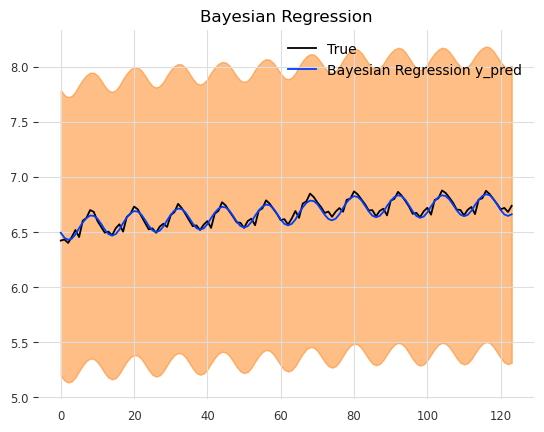

BAYESIAN REGRESSION MEAN WINKLER SCORE:  14.1393


In [44]:
## 4. AUTOREGRESSIVE
ar_order = 1
# ar_order = 0
max_trunc_start = int(np.max(trend_spans + fourier_periods) + 1 + ar_order)
max_trunc_end = 1  ## forecast horizon

trend_seasonal_features = np.concatenate((trend_features, fourier_features), axis=1)

# trend_seasonal_features = trend_features
# trend_seasonal_features = fourier_features

ar_features = []
for ar_order_i in range(ar_order + 1):
    ar_lagged = pd.DataFrame(trend_seasonal_features).shift(ar_order_i)
    ar_features.append(ar_lagged.values)

ar_features = np.concatenate(np.array(ar_features), axis=1)

ar_features = ar_features[max_trunc_start:-max_trunc_end]  ## truncate nan values

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Assuming data_series, ar_features, max_trunc_start, max_trunc_end are defined and available in your context

# Prepare data
Y_h1 = data_series.shift(-1).values[max_trunc_start:-max_trunc_end, np.newaxis]  # truncate NaN values
X_all_AR = ar_features

X_train_AR, X_test_AR, Y_train, Y_test = train_test_split(X_all_AR, Y_h1, test_size=0.5, shuffle=False)

# Fit Bayesian Ridge Regression model
model_AR = BayesianRidge()
model_AR.fit(X_train_AR, Y_train)

# Predict and calculate residuals
Y_pred_all, Y_pred_std = model_AR.predict(X_all_AR, return_std=True)
residuals_all = (Y_h1[:, 0] - Y_pred_all).flatten()

# Calculate and print metrics
mae = np.abs(residuals_all).mean()
r2 = r2_score(Y_h1, Y_pred_all)

print(f"BAYESIAN REGRESSION MAE: {mae}")
print(f"BAYESIAN REGRESSION R2: {r2}")

# Plot the results
time_series = np.arange(len(Y_h1))  # Assuming time_series is a range for plotting

plt.figure()
plt.plot(time_series, Y_h1, label="True")
plt.plot(time_series, Y_pred_all, label="Bayesian Regression y_pred")
plt.fill_between(
    time_series,
    Y_pred_all + 2 * Y_pred_std,
    Y_pred_all - 2 * Y_pred_std,
    alpha=0.5,
    color="tab:orange",
)
plt.title("Bayesian Regression")
plt.legend()
plt.show()

# Calculate and print the Winkler Score
upper_bounds_bayesian = Y_pred_all + 2 * Y_pred_std
lower_bounds_bayesian = Y_pred_all - 2 * Y_pred_std

winkler_scores_bayesian = upper_bounds_bayesian - lower_bounds_bayesian

for i, y_ in enumerate(Y_h1):
    lower_bound_i = lower_bounds_bayesian[i]
    upper_bound_i = upper_bounds_bayesian[i]

    if y_ < lower_bounds_bayesian[i]:
        winkler_scores_bayesian[i] = winkler_scores_bayesian[i] + penalty_factor * (lower_bound_i - y_)
    elif y_ > upper_bounds_bayesian[i]:
        winkler_scores_bayesian[i] = winkler_scores_bayesian[i] + penalty_factor * (y_ - upper_bound_i)

mean_winkler_score_bayesian = np.exp(np.mean(winkler_scores_bayesian))
print(f"BAYESIAN REGRESSION MEAN WINKLER SCORE: {mean_winkler_score_bayesian: .4f}")


Standard NN 0 LOSS 0:  8.9313
Standard NN 0 LOSS 50:  0.0496
Standard NN 0 LOSS 100:  0.0701
Standard NN 0 LOSS 150:  0.2701
Standard NN 0 LOSS 200:  0.4695
Standard NN 0 LOSS 250:  0.4577
Standard NN 0 LOSS 300:  0.2227
Standard NN 0 LOSS 350:  0.1131
Standard NN 0 LOSS 400:  0.2154
Standard NN 0 LOSS 450:  0.1158
Standard NN 0 LOSS 500:  0.2048
Standard NN 0 LOSS 550:  0.0530
Standard NN 0 LOSS 600:  0.0955
Standard NN 0 LOSS 650:  0.3609
Standard NN 0 LOSS 700:  0.2887
Standard NN 0 LOSS 750:  0.2445
Standard NN 0 LOSS 800:  0.0991
Standard NN 0 LOSS 850:  0.1605
Standard NN 0 LOSS 900:  0.1014
Standard NN 0 LOSS 950:  0.1584
Standard NN 0 LOSS 1000:  0.0972
Standard NN 0 LOSS 1050:  0.1516
Standard NN 0 LOSS 1100:  0.0971
Standard NN 0 LOSS 1150:  0.1487
Standard NN 0 LOSS 1200:  0.0959
Standard NN 0 LOSS 1250:  0.1451
Standard NN 0 LOSS 1300:  0.0873
Standard NN 0 LOSS 1350:  0.0557
Standard NN 0 LOSS 1400:  0.0519
Standard NN 0 LOSS 1450:  0.0614
Standard NN 0 LOSS 1500:  0.0613


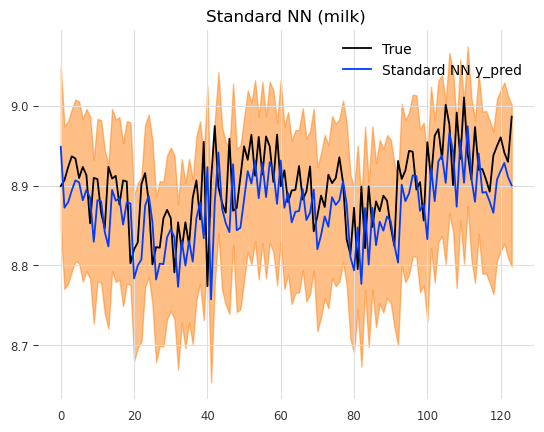

Standard NN MAE: 0.05587832653300252
Standard NN R2: -0.39588818147231497
Standard NN MEAN WINKLER SCORE:  1.2927


/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_81860/4280987166.py:86: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  winkler_scores_standard[i] = winkler_scores_standard[i] + penalty_factor * (y_ - upper_bound_i)


In [45]:

class StandardNNRegression(torch.nn.Module):
    def __init__(self, input_size, hidden_nodes, n_layers):
        super(StandardNNRegression, self).__init__()
        layers = [torch.nn.Linear(input_size, hidden_nodes), torch.nn.ReLU()]
        for _ in range(n_layers - 1):
            layers.extend([torch.nn.Linear(hidden_nodes, hidden_nodes), torch.nn.ReLU()])
        layers.append(torch.nn.Linear(hidden_nodes, 1))
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    

    
n_ensemble_standard = 5
n_epochs = 2000
standard_nn_models = [
    StandardNNRegression(input_size=1, hidden_nodes=50, n_layers=3).to(device)
    for _ in range(n_ensemble_standard)
]

optims_standard = [torch.optim.Adam(nn_model.parameters(), lr=1e-2) for nn_model in standard_nn_models]

for nn_i in range(len(standard_nn_models)):
    for epoch in range(n_epochs):
        y_pred_tensor = standard_nn_models[nn_i](X_train_tensor)
        loss = (torch.abs(y_pred_tensor - Y_train_tensor)).mean()

        optims_standard[nn_i].zero_grad()
        loss.backward()
        optims_standard[nn_i].step()

        if epoch % 50 == 0:
            print(f"Standard NN {nn_i} LOSS {epoch}: {loss.item(): .4f}")

y_pred_tensor_all_standard = torch.stack(
    [nn_model(X_tensor) for nn_model in standard_nn_models]
)
y_pred_mean_standard = y_pred_tensor_all_standard.mean(0).squeeze(-1).detach().cpu().numpy()
y_pred_std_standard = y_pred_tensor_all_standard.std(0).squeeze(-1).detach().cpu().numpy()

import matplotlib.pyplot as plt

# Ensure that Y_all and predictions have the same length
n_plot_points = min(len(time_series), len(Y_all), len(y_pred_mean_standard))
time_series = time_series[:n_plot_points]
Y_all = Y_all[:n_plot_points]
y_pred_mean_standard = y_pred_mean_standard[:n_plot_points]
y_pred_std_standard = y_pred_std_standard[:n_plot_points]

plt.figure()
plt.plot(time_series, Y_all, label="True")
plt.plot(time_series, y_pred_mean_standard, label="Standard NN y_pred")
plt.fill_between(
    time_series,
    y_pred_mean_standard + 2 * y_pred_std_standard,
    y_pred_mean_standard - 2 * y_pred_std_standard,
    alpha=0.5,
    color="tab:orange",
)
plt.title(f"Standard NN ({dataset_name})")
plt.legend()
plt.show()

print(f"Standard NN MAE: {(np.abs(y_pred_mean_standard - Y_all)).mean()}")
print(f"Standard NN R2: {r2_score(Y_all, y_pred_mean_standard)}")

#### Calculate Winkler Score ####
test_args = np.arange(len(y_pred_mean_standard) // 2, len(y_pred_mean_standard))

# Ensure that test_args slices are within the bounds
test_args = test_args[test_args < len(y_pred_mean_standard)]

upper_bounds_standard = y_pred_mean_standard[test_args] + 2 * y_pred_std_standard[test_args]
lower_bounds_standard = y_pred_mean_standard[test_args] - 2 * y_pred_std_standard[test_args]

winkler_scores_standard = upper_bounds_standard - lower_bounds_standard

for i, y_ in enumerate(Y_all[test_args]):
    lower_bound_i = lower_bounds_standard[i]
    upper_bound_i = upper_bounds_standard[i]

    if y_ < lower_bound_i:
        winkler_scores_standard[i] = winkler_scores_standard[i] + penalty_factor * (lower_bound_i - y_)
    elif y_ > upper_bound_i:
        winkler_scores_standard[i] = winkler_scores_standard[i] + penalty_factor * (y_ - upper_bound_i)

mean_winkler_score_standard = np.exp(np.mean(winkler_scores_standard))

print(f"Standard NN MEAN WINKLER SCORE: {mean_winkler_score_standard: .4f}")




0 LOSS 0:  6.5561
0 LOSS 50:  0.0507
0 LOSS 100:  0.0253
0 LOSS 150:  0.0341
0 LOSS 200:  0.0359
0 LOSS 250:  0.0266
0 LOSS 300:  0.0284
0 LOSS 350:  0.0296
0 LOSS 400:  0.0158
0 LOSS 450:  0.0122
0 LOSS 500:  0.0112
0 LOSS 550:  0.0191
0 LOSS 600:  0.0128
0 LOSS 650:  0.0232
0 LOSS 700:  0.0194
0 LOSS 750:  0.0159
0 LOSS 800:  0.0173
0 LOSS 850:  0.0146
0 LOSS 900:  0.0151
0 LOSS 950:  0.0194
0 LOSS 1000:  0.0164
0 LOSS 1050:  0.0186
0 LOSS 1100:  0.0147
0 LOSS 1150:  0.0214
0 LOSS 1200:  0.0205
0 LOSS 1250:  0.0147
0 LOSS 1300:  0.0129
0 LOSS 1350:  0.0177
0 LOSS 1400:  0.0126
0 LOSS 1450:  0.0187
0 LOSS 1500:  0.0119
0 LOSS 1550:  0.0224
0 LOSS 1600:  0.0195
0 LOSS 1650:  0.0164
0 LOSS 1700:  0.0157
0 LOSS 1750:  0.0180
0 LOSS 1800:  0.0172
0 LOSS 1850:  0.0156
0 LOSS 1900:  0.0154
0 LOSS 1950:  0.0113
1 LOSS 0:  6.2842
1 LOSS 50:  0.0405
1 LOSS 100:  0.0313
1 LOSS 150:  0.0229
1 LOSS 200:  0.0200
1 LOSS 250:  0.0356
1 LOSS 300:  0.0244
1 LOSS 350:  0.0177
1 LOSS 400:  0.0315
1 LOSS

/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_81860/1930167534.py:193: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  winkler_scores[i] = winkler_scores[i] + penalty_factor * (y_ - upper_bound_i)


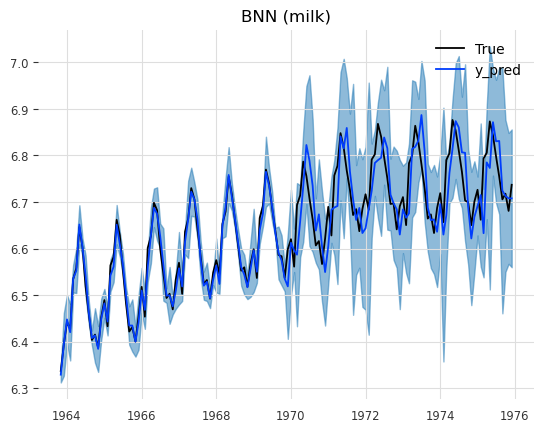

In [46]:

import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

class NeuralHarmonicModel(torch.nn.Module):
    def __init__(
        self,
        input_size=3,
        hidden_nodes=50,
        n_layers=1,
        k_order=5,
        t_order=1,
        n_trends=3,
    ):
        super().__init__()

        self.input_size = input_size
        self.hidden_nodes = hidden_nodes
        self.n_layers = n_layers
        self.k_order = k_order
        self.t_order = t_order

        self.input_layer_season = torch.nn.Linear(input_size, hidden_nodes)
        self.input_layer_trend = torch.nn.Linear(n_trends, hidden_nodes)

        self.hidden_layers_season = []
        for i in range(self.n_layers):
            self.hidden_layers_season += [
                torch.nn.Linear(self.hidden_nodes, self.hidden_nodes),
                torch.nn.GELU(),
            ]
        self.hidden_layers_season = torch.nn.Sequential(*self.hidden_layers_season)

        self.hidden_layers_trend = []
        for i in range(self.n_layers):
            self.hidden_layers_trend += [
                torch.nn.Linear(self.hidden_nodes, self.hidden_nodes),
                torch.nn.GELU(),
            ]
        self.hidden_layers_trend = torch.nn.Sequential(*self.hidden_layers_trend)

        self.activation_func = torch.nn.functional.tanh

        self.T = torch.nn.Parameter(torch.Tensor([[10.0]]))

        step_period = 3.0
        self.Ts = torch.nn.Parameter(
            torch.from_numpy(
                np.linspace(step_period, step_period * self.t_order, self.t_order)
            ).float()
        )

        self.constant = torch.nn.Parameter(torch.Tensor([[1.0]]))

        self.ABs = torch.nn.Parameter(
            torch.Tensor(
                [[[0.01, 0.01] for k in range(k_order)] for t_ in range(t_order)]
            )
        )

        self.output_layer_trend = torch.nn.Linear(self.hidden_nodes, 1)
        self.output_layer_season = torch.nn.Linear(self.hidden_nodes, 1)

    def forward(self, x, t, trend=None):
        fourier_components = 0
        for t_order in range(self.t_order):
            T_ = (torch.nn.functional.softplus(self.Ts[t_order]) + 1).reshape(-1, 1)
            for k in range(self.k_order):
                A, B = self.ABs[t_order][k]
                A = A.reshape(-1, 1)
                B = B.reshape(-1, 1)

                fourier_components += A * torch.sin(
                    2 * torch.pi * t * k / T_
                ) + B * torch.cos(2 * torch.pi * t * k / T_)

        repr_trend = self.activation_func(self.input_layer_trend(trend))
        repr_trend = self.hidden_layers_trend(repr_trend)
        yhat_trend = self.output_layer_trend(repr_trend)

        residual = x - (yhat_trend + fourier_components)
        repr_season = self.activation_func(self.input_layer_season(residual))
        repr_season = self.hidden_layers_season(repr_season)
        yhat_season = self.output_layer_season(repr_season)
        return yhat_season + yhat_trend + fourier_components

# Ensure MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

torch.manual_seed(99)
np.random.seed(7977)

X_all = data_np[:-1, np.newaxis]
Y_all = data_np[1:, np.newaxis]
trend_tensor = trend_terms[:-1]
trend_tensor = torch.from_numpy(trend_tensor).float().to(device)

X_tensor = torch.from_numpy(X_all).float().to(device)
t_tensor = torch.from_numpy(np.arange(n_obs)[:-1, np.newaxis]).float().to(device)
Y_tensor = torch.from_numpy(Y_all).float().to(device)

(
    X_train_tensor,
    X_test_tensor,
    Y_train_tensor,
    Y_test_tensor,
    t_train_tensor,
    t_test_tensor,
    trend_train_tensor,
    trend_test_tensor,
) = train_test_split(
    X_tensor, Y_tensor, t_tensor, trend_tensor, test_size=0.5, shuffle=False
)

n_ensemble = 5

nn_models = [
    NeuralHarmonicModel(
        input_size=1,
        hidden_nodes=50,
        n_layers=1,
        k_order=5,
        t_order=5,
        n_trends=len(trend_spans),
    ).to(device)
    for i in range(n_ensemble)
]

optims = [torch.optim.Adam(nn_model.parameters(), lr=1e-2) for nn_model in nn_models]

n_epochs = 2000

for nn_i in range(len(nn_models)):
    for epoch in range(n_epochs):
        y_pred_tensor = nn_models[nn_i](
            x=X_train_tensor, t=t_train_tensor, trend=trend_train_tensor
        )
        loss = (torch.abs(y_pred_tensor - Y_train_tensor)).mean()

        optims[nn_i].zero_grad()
        loss.backward()
        optims[nn_i].step()

        if epoch % 50 == 0:
            print(f"{nn_i} LOSS {epoch}: {loss.item() : .4f}")

y_pred_tensor_all = torch.stack(
    [nn_model(x=X_tensor, t=t_tensor, trend=trend_tensor) for nn_model in nn_models]
)
y_pred_mean = y_pred_tensor_all.mean(0).squeeze(-1).detach().cpu().numpy()
y_pred_std = y_pred_tensor_all.std(0).squeeze(-1).detach().cpu().numpy()

###===PLOTS===
time_series = df_data.index[trunc_start + 1 :]
plt.figure()
plt.plot(time_series, Y_all, label="True")
plt.plot(time_series, y_pred_mean, label="y_pred")
plt.fill_between(
    time_series,
    y_pred_mean + 2 * y_pred_std,
    y_pred_mean - 2 * y_pred_std,
    alpha=0.5,
    color="tab:blue",
)
plt.title(f"BNN ({dataset_name})")
plt.legend()

print(f"MAE: {(np.abs(y_pred_mean - Y_all)).mean()}")
print(f"R2 : {r2_score(Y_all, y_pred_mean)}")

########### EVALUATE WINKLER  SCORE #######
test_args = np.arange(len(y_pred_mean) // 2, len(y_pred_mean))

upper_bounds = y_pred_mean[test_args] + 2 * y_pred_std[test_args]
lower_bounds = y_pred_mean[test_args] - 2 * y_pred_std[test_args]

winkler_scores = upper_bounds - lower_bounds
alpha = 0.05
penalty_factor = 2 / alpha

for i, y_ in enumerate(Y_all[test_args]):
    lower_bound_i = lower_bounds[i]
    upper_bound_i = upper_bounds[i]

    if y_ < lower_bounds[i]:
        winkler_scores[i] = winkler_scores[i] + penalty_factor * (lower_bound_i - y_)
    elif y_ > upper_bounds[i]:
        winkler_scores[i] = winkler_scores[i] + penalty_factor * (y_ - upper_bound_i)

mean_winkler_score = np.exp(np.mean(winkler_scores))

print(f"MEAN WINKLER SCORE: {mean_winkler_score : .4f}")

